In [2]:
from graphviz import Digraph
# import thermo.chemical as chem
import CoolProp.CoolProp as CP
import sys, os
import pandas as pd
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..', 'data'))

In [3]:
import thermo_data_simple as tds

In [4]:
chem_ex = pd.read_csv('chem_ex.csv')
chem_ex

,component,chem_exergy
0,methanol,718.00
1,ethanol,1356.90
2,ammonia,337.90
3,methane,831.20
4,hydrogen,236.09


In [5]:
ex=chem_ex.set_index('component').T.to_dict('list')
ex['methanol']
# chem_ex['component'][1]

[718.0]

## Electrolysis
H2O + energy = H2 + 1/2 O2  
For the efficiency of electrolysis process, see [here](https://en.wikipedia.org/wiki/Electrolysis_of_water#Efficiency)
* Alkaline technology: ~ 70%
* Proton Exchange Membranes (PEM): ~ 80% (and apparently increasing)

## Other methods
* See [this](https://www.energy.gov/sites/prod/files/2017/11/f46/HPTT%20Roadmap%20FY17%20Final_Nov%202017.pdf)
* Also see [this](https://www.sciencedirect.com/science/article/pii/S0360319919345276)

In [6]:
# Electrolysis reaction and its energy requirement
h_form_H2O = tds.get_property('H2O', 'dh_form')
dg_electrolysis = tds.get_property('H2', 'dg_form')+ \
                  1/2*tds.get_property('O2', 'dg_form')- \
                  tds.get_property('H2O', 'dg_form')
dh_electrolysis = -h_form_H2O # J/mol
dh_electrolysis, dg_electrolysis # J/mol

T_env = 20+273.15
p_env = 1.01e5 # Pa
rho_H2 = CP.PropsSI('DMOLAR', 'T', T_env, 'P', p_env, 'H2') # m3/mol
eta_electrolysis = 0.7 # efficiency
ex_H2_prod = dh_electrolysis/eta_electrolysis
ex_H2_prod # J/mol at environmental condition

345448.5714285715

In [7]:
# another way!
ex_electrolys = np.array([4.5, 5.5]) # kWh/m3 at standard condition
rho_h2 = CP.PropsSI('DMOLAR', 'T', 25+273.15, 'P', 101325, 'H2') # mol/m3
# rho_h2, 101325/(8.314*(25+273.15)) # seems correct
ex_H2 = np.mean(ex_electrolys*3600/rho_h2) # kJ/mol
print(ex_H2)

440.63955629057955


## CO2 recycling
Sabatier reaction:  
CO2 + 4 H2 = CH4 + 2 H2O  
At 400 degC  
High pressure (assume 100 bar)  

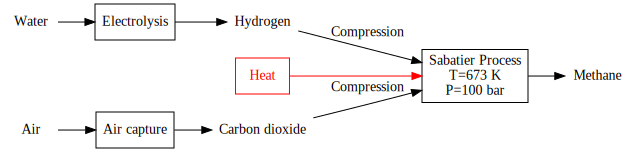

In [8]:
# sabatier
f = Digraph('Process flow diagram', format='svg', filename='sabatier.gv')
f.attr(rankdir='LR', size='10,6')

f.attr('node', shape = 'none')
f.node('CO2', label = 'Carbon dioxide')
f.node('H2', label = 'Hydrogen')
f.node('Air')
f.node('Methane')
f.node('Water')

f.attr('node', shape = 'rectangle')
f.node('HP', label = 'Sabatier Process\nT=673 K\nP=100 bar')
f.node('CD', label = 'Air capture')
f.node('Electrolysis')

f.edge('CO2', 'HP', label='Compression')
f.edge('H2', 'HP', label='Compression')
f.edge('HP', 'Methane')
f.edge('Air', 'CD')
f.edge('CD', 'CO2')
f.edge('Water', 'Electrolysis')
f.edge('Electrolysis', 'H2')
f.edge('Heat', 'HP', color='red')
f.node('Heat', color='red', fontcolor='red')

f.render()
f

In [9]:
from CoolProp.CoolProp import PropsSI

In [10]:
# Sabatier reaction
# assume full conversion
ex_CO2 = 400 # kJ/mol
p_r = 100e5 # Pa
T_r = 400+273.15 # K
p_in = 1e5 # Pa
T_in = 273.15+25 # K
pr = 3.5

eta_comp = 0.8

# 100 bar, 3 stage compressor
n = np.round(np.log(p_r/p_in)/np.log(pr))
print(n)
pr = np.exp(np.log(p_r/p_in)/round(n))
print(pr)

S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'CO2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'CO2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'CO2')
comp_power_CO2 = n*(H_out-H_in)/eta_comp/1000 # kJ/mol
T_comp = PropsSI('T', 'P', pr*p_in, 'Smolar', S_out, 'CO2')
print(comp_power_CO2)


S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'H2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'H2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'H2')
comp_power_H2 = 4*n*(H_out-H_in)/eta_comp/1000 # kJ/mol
print(comp_power_H2, 'kJ/mol')

ex_warm = PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'CO2')+4*PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'H2')- \
PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'CO2')-4*PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'H2')
ex_warm = ex_warm/1000 # kJ/mol
print(ex_warm, 'kJ/mol')

ex_sabatier = ex_CO2+4*ex_H2+comp_power_CO2+comp_power_H2+ex_warm

print(ex_sabatier, 'kJ/mol')
print(ex['methane'])

print('sabatier efficiency = ', ex['methane']/ex_sabatier)

4.0
3.1622776601683795
16.124685597909266
67.69161149397908 kJ/mol
49.56473022261817 kJ/mol
2295.9392524768245 kJ/mol
[831.2]
sabatier efficiency =  [0.36203048]


In [24]:
ex_H2

440.63955629057955

Energy requirement:
* CO2 production or extraction
    - extraction from the air
    - biomass
    - Fossil-fuel based
* H2 production
* Compression and heat

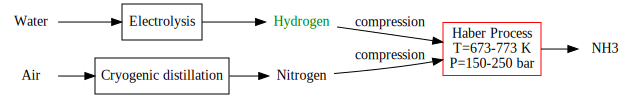

In [10]:
# N2 + 3 H2 = 2 NH3
# Pressure = 150 to 250 bar
# Temperature = 400 to 500 degC
f = Digraph('Process flow diagram', format='svg', filename='haber.gv')
f.attr(rankdir='LR', size='10,6')

f.attr('node', shape = 'none')
f.node('N2', label = 'Nitrogen')
f.node('H2', label = 'Hydrogen', fontcolor='green')
f.node('Air')
f.node('NH3')
f.node('Water')

f.attr('node', shape = 'rectangle')
f.node('HP', label = 'Haber Process\nT=673-773 K\nP=150-250 bar', color='red')
f.node('CD', label = 'Cryogenic distillation')
f.node('Electrolysis')

f.edge('N2', 'HP', label='compression')
f.edge('H2', 'HP', label='compression')
f.edge('HP', 'NH3')
f.edge('Air', 'CD')
f.edge('CD', 'N2')
f.edge('Water', 'Electrolysis')
f.edge('Electrolysis', 'H2')

f.render()
f

## Process flow diagram
![pfd](./fsm.gv.svg)

In [12]:
T = 400+273.15 # K
P = 100e5 # Pa
# skip the thermo package for the time being
# CO2 = chem.Chemical('CO2', T=T, P=P)
# H2 = chem.Chemical('H2')
# CH4 = chem.Chemical('CH4')
# H2O = chem.Chemical('H2O')

In [13]:
h_form_CO2 = tds.get_property('CO2', 'dh_form')
h_CO2 = CP.PropsSI('Hmolar', 'T', T, 'P', P, 'CO2')
h_form_CO2+h_CO2

-355470.54619069945

## Haber process
N2 + 3 H2 = 2 NH3  

Pressure = 150 to 250 bar  
Temperature = 400 to 500 degC

In [25]:
# assume full conversion
ex_N2 = 9.5 # kJ/mol
p_r = 250e5 # Pa
T_r = 400+273.15 # K
p_in = 1e5 # Pa
T_in = 273.15+25 # K
pr = 3.5

eta_comp = 0.8

# 100 bar, 3 stage compressor
n = np.round(np.log(p_r/p_in)/np.log(pr))
print(n)
pr = np.exp(np.log(p_r/p_in)/round(n))
print(pr)

S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'N2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'N2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'N2')
comp_power_N2 = n*(H_out-H_in)/eta_comp/1000 # kJ/mol
T_comp = PropsSI('T', 'P', pr*p_in, 'Smolar', S_out, 'N2')
print(comp_power_N2)


S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'H2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'H2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'H2')
comp_power_H2 = 3*n*(H_out-H_in)/eta_comp/1000 # kJ/mol
print(comp_power_H2, 'kJ/mol')

ex_warm = PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'N2')+3*PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'H2')- \
PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'N2')-3*PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'H2')
ex_warm = ex_warm/1000 # kJ/mol
print(ex_warm, 'kJ/mol')

ex_haber = ex_N2+3*ex_H2+comp_power_N2+comp_power_H2+ex_warm

print(ex_haber, 'kJ/mol')
print(ex['ammonia'])

print('Haber efficiency = ', 2*ex['ammonia'][0]/ex_haber)

4.0
3.976353643835253
20.978039243159184
63.02313995977227 kJ/mol
27.921484102266696 kJ/mol
1443.341332176937 kJ/mol
[337.9]
Haber efficiency =  0.4682191141721941


In [15]:
ex_N2

9.5

## Fischer-Tropsch process
(2n + 1) H2 + n CO → CnH2n+2 + n H2O

* Requires CO and H2
* T = 150 to 300 degC
* P = 1 to 100 bar

## Methanol
CO2 + 3 H2 → CH3OH + H2O

* p = 50-100 bar
* T = 250 degC

Requires H2 and in some cases CO
    

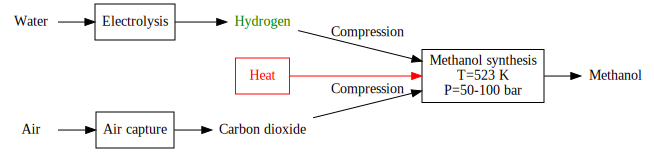

In [6]:
# methanol
f = Digraph('Process flow diagram', format='svg', filename='methanol.gv')
f.attr(rankdir='LR', size='10,6')

f.attr('node', shape = 'none')
f.node('CO2', label = 'Carbon dioxide')
f.node('H2', label = 'Hydrogen', fontcolor='green')
f.node('Air')
f.node('Methanol')
f.node('Water')

f.attr('node', shape = 'rectangle')
f.node('HP', label = 'Methanol synthesis\nT=523 K\nP=50-100 bar')
f.node('CD', label = 'Air capture')
f.node('Electrolysis')

f.edge('CO2', 'HP', label='Compression')
f.edge('H2', 'HP', label='Compression')
f.edge('HP', 'Methanol')
f.edge('Air', 'CD')
f.edge('CD', 'CO2')
f.edge('Water', 'Electrolysis')
f.edge('Electrolysis', 'H2')
f.edge('Heat', 'HP', color='red')
f.node('Heat', color='red', fontcolor='red')

f.render()
f

In [27]:
# methanol
# assume full conversion
ex_CO2 = 400 # kJ/mol
p_r = 100e5 # Pa
T_r = 250+273.15 # K
p_in = 1e5 # Pa
T_in = 273.15+25 # K
pr = 3.5

eta_comp = 0.8

# 100 bar, 3 stage compressor
n = np.round(np.log(p_r/p_in)/np.log(pr))
print(n)
pr = np.exp(np.log(p_r/p_in)/round(n))
print(pr)

S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'CO2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'CO2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'CO2')
comp_power_CO2 = n*(H_out-H_in)/eta_comp/1000 # kJ/mol
T_comp = PropsSI('T', 'P', pr*p_in, 'Smolar', S_out, 'CO2')
print(comp_power_CO2, 'kJ/mol')


S_in = PropsSI('Smolar', 'T', T_in, 'P', p_in, 'H2')
H_in = PropsSI('Hmolar', 'T', T_in, 'P', p_in, 'H2')
S_out = S_in
H_out = PropsSI('Hmolar', 'P', pr*p_in, 'Smolar', S_out, 'H2')
comp_power_H2 = 3*n*(H_out-H_in)/eta_comp/1000 # kJ/mol
print(comp_power_H2, 'kJ/mol')

ex_warm = PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'CO2')+3*PropsSI('Hmolar', 'T', T_r, 'P', p_r, 'H2')- \
PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'CO2')-3*PropsSI('Hmolar', 'T', T_comp, 'P', p_r, 'H2')
ex_warm = ex_warm/1000 # kJ/mol
print(ex_warm, 'kJ/mol')

ex_methanol = ex_CO2+3*ex_H2+comp_power_CO2+comp_power_H2+ex_warm

print(ex_methanol, 'kJ/mol')
print(ex['methanol'])

print('methanol efficiency = ', ex['methanol']/ex_methanol)

4.0
3.1622776601683795
16.124685597909266 kJ/mol
50.76870862048432 kJ/mol
20.10777026615257 kJ/mol
1808.919833356285 kJ/mol
[718.0]
methanol efficiency =  [0.39692196]


See a list of components [here](http://www.coolprop.org/fluid_properties/PurePseudoPure.html#list-of-fluids)



In [28]:
1000/24

41.666666666666664

In [16]:
from CoolProp.CoolProp import PropsSI
T1 = 25+273.17
p1 = 1e5

H_H2 = PropsSI("Hmolar", "P", p1, "T", T1, "H2")
H_O2 = PropsSI("Hmolar", "P", p1, "T", T1, "O2")
H_H2O = PropsSI("Hmolar", "P", p1, "T", T1, "H2O")

# Perry's chemical engineers' handbook
# http://web.mit.edu/2.813/www/readings/APPENDIX.pdf

dH_electrolysis = H_H2+1/2*H_O2 - H_H2O
print(dH_electrolysis)
print(H_H2)

10371.312768632817
7926.618188636264


In [17]:
H1 = PropsSI("Hmolar", "P", 1e5, "T", 300, "H2")
H2 = PropsSI("Hmolar", "P", 100e5, "T", 300, "H2")
print(H2-H1)

V = 1/PropsSI("Dmolar", "P", 200e5, "T", 80+273.15, "H2")
print(V)

94.67214965468065
0.00016256103926824098


In [18]:
H2 = PropsSI("Hmolar", "P", p1, "T", T1, "NH3")
H2 = PropsSI("Hmolar", "P", p1, "T", T1, "CO2")
H2 = PropsSI("Hmolar", "P", p1, "T", T1, "N2")
H2 = PropsSI("Hmolar", "P", p1, "T", T1, "CH4")

Z = PropsSI("Z", "P", 200e5, "T", 353.15, "CH4")
print(Z)

0.9277802771885066


In [19]:
PropsSI("Hmolar", "P", 1e5, "T", 300, "H2O")

2029.4862307757198